# In this notebook we use our cluster assignments to make song recommendations

# Load data

In [6]:
 #!pip install --quiet pyarrow polars

In [7]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

RANDOM_STATE = 42

# if local
users_with_clusters_path = "data/users_with_clusters_df.parquet"

In [8]:
# if local
users_with_clusters_path = "data/users_clusters_df.parquet"
songs_path = "data/songs_df_cleaned.parquet"
track_metadata_path = "data/track_metadata.db"

In [9]:
# # if google collab
# users_with_clusters_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_clusters_df.parquet"
# songs_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_cleaned.parquet"
# track_metadata_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/track_metadata.db"
#
# from google.colab import drive
#
# drive.mount('/content/drive')

In [10]:
track_metadata_conn = sqlite3.connect(track_metadata_path)
track_metadata_sql_query = "SELECT * FROM songs"
song_metadata_df = pd.read_sql_query(
    track_metadata_sql_query,
    track_metadata_conn
).drop_duplicates(subset=['song_id'])
track_metadata_conn.close()


In [11]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(users_with_clusters_path)
songs_polars_df = pl.read_parquet(songs_path)

In [12]:
# This conversion can take 51s on regular ram, 21 seconds on high ram mode
users_df = users_polars_df.to_pandas(use_pyarrow_extension_array=True)
songs_df = songs_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [13]:
len(users_df)

292126

In [14]:
users_df.head(5)

,user_id,hdb_cluster,kmeans_cluster
0,00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,59,1
1,00007ed2509128dcdd74ea3aac2363e24e9dc06b,58,20
2,0000d3c803e068cf1da17724f1674897b2dd7130,-1,20
3,0001c671d4962f5449e225cab018d6ca290c7ad2,53,17
4,0001cbd80da8b7be9e6fe8ef2d3749e68b08ecd2,59,17


In [15]:
len(songs_df)

26102714

In [16]:
songs_df.head()

,user_id,song_id,plays,track_id,title,release,duration,artist_id,artist_name,artist_familiarity,artist_hotttnesss,year,majority_genre,minority_genre,tot_track_time
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,153.59955,ARHYUI71187FB48366,Billy Preston,0.580555,0.482492,1974,RnB,<NA>,153.59955
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,358.24281,ARC1SF21187FB51D0F,Paco De Lucia,0.633119,0.417718,1976,Electronic,Metal,716.48562
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,266.34404,ARMS97V1187B99DD98,Josh Rouse,0.675339,0.509058,2002,Rock,<NA>,266.34404
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,12 segundos de oscuridad,10 + Downloaded,246.83057,AR1BQ6Y1187B98D586,Jorge Drexler,0.641037,0.412069,2006,Latin,Pop,493.66114
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Stronger,Graduation,311.84934,ARRH63Y1187FB47783,Kanye West,0.877214,1.082503,2007,Rap,<NA>,311.84934


# Playlist Generation

In [17]:
users_songs_clusters = pd.merge(songs_df, users_df, on='user_id')
users_cols = ['user_id', 'song_id', 'plays', 'title', 'release', 'artist_name', 'artist_id', 'duration', 'year',
              'majority_genre', 'kmeans_cluster', 'hdb_cluster', 'tot_track_time']

users_songs_clusters = users_songs_clusters[
    users_cols]  #.drop(columns=["track_id", "artist_id", "artist_mbid", "shs_perf", "shs_work","track_7digitalid"])#, 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'])  #, 'PC6'])
global_plays = users_songs_clusters.groupby('song_id')['plays'].sum().reset_index(name='global_plays')
users_songs_clusters = users_songs_clusters.merge(global_plays, on='song_id')

In [18]:
users_songs_clusters.head(1000)

,user_id,song_id,plays,title,release,artist_name,artist_id,duration,year,majority_genre,kmeans_cluster,hdb_cluster,tot_track_time,global_plays
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,ARHYUI71187FB48366,153.59955,1974,RnB,11,59,153.59955,545
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,ARC1SF21187FB51D0F,358.24281,1976,Electronic,11,59,716.48562,2272
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,Under Cold Blue Stars,Under Cold Blue Stars,Josh Rouse,ARMS97V1187B99DD98,266.34404,2002,Rock,11,59,266.34404,253
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,12 segundos de oscuridad,10 + Downloaded,Jorge Drexler,AR1BQ6Y1187B98D586,246.83057,2006,Latin,11,59,493.66114,900
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,ARRH63Y1187FB47783,311.84934,2007,Rap,11,59,311.84934,18306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7e2b716907a9a295d92c2f35d7e260aeee2b32cf,SOQXRUN12AC4689E24,2,Don't Trust The Kids,Blackouts,Ashra,AR7F48V1187B9AC54C,194.76853,1978,Rock,9,-1,389.53706,3572
996,7e2b716907a9a295d92c2f35d7e260aeee2b32cf,SORNPBR12AB0185410,1,I Wish,Converting Vegetarians,Infected Mushroom,ARY7DQ91187B98C85E,180.94975,2003,Rock,9,-1,180.94975,1452
997,7e2b716907a9a295d92c2f35d7e260aeee2b32cf,SOSBQSS12AB0189C58,3,First Time,Greyest Of Blue Skies,Finger Eleven,AR6BNBY1187B998232,266.23955,2000,Rock,9,-1,798.71865,228
998,7e2b716907a9a295d92c2f35d7e260aeee2b32cf,SOTELBF12A6701FA4A,1,Numb,Dummy,Portishead,ARJVTD81187FB51621,238.0273,1994,Electronic,9,-1,238.0273,1536


In [19]:
# Extract metadata once (fastest way to keep columns without slowing down groupby)
meta_cols = ['song_id', 'global_plays', 'title', 'release', 'artist_name', 'artist_id', 'duration', 'year',
             'majority_genre', 'tot_track_time']
song_meta = users_songs_clusters[meta_cols].drop_duplicates('song_id')

# KMeans: Group by IDs (fast), sum, sort, take top 20, then restore metadata
songs_per_kmeans_cluster = (
    users_songs_clusters.groupby(['kmeans_cluster', 'song_id'], as_index=False)['plays'].sum()
    .sort_values(['kmeans_cluster', 'plays'], ascending=[True, False])
    .groupby('kmeans_cluster').head(20)
    .merge(song_meta, on='song_id')
)

# HDBSCAN: Group by IDs (fast), sum, sort, take top 20, then restore metadata
songs_per_hdb_cluster = (
    users_songs_clusters.groupby(['hdb_cluster', 'song_id'], as_index=False)['plays'].sum()
    .sort_values(['hdb_cluster', 'plays'], ascending=[True, False])
    .groupby('hdb_cluster').head(20)
    .merge(song_meta, on='song_id')
)

print("Top 20 KMeans Songs:")
display(songs_per_kmeans_cluster.head(100))
print("\nTop 20 HDBSCAN Songs:")
display(songs_per_hdb_cluster.head())

Top 20 KMeans Songs:


,kmeans_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,0,SONYKOW12AB01849C9,4536,106574,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,1572.75111
1,0,SOBONKR12A58A7A7E0,4376,199599,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,6221.9898
2,0,SOFLJQZ12A6D4FADA6,3586,63869,Tive Sim,Nova Bis-Cartola,Cartola,ARRYVEO1187B98B5F5,127.242,1974,Latin,127.242
3,0,SOSXLTC12AF72A7F54,3301,144444,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
4,0,SOTWNDJ12A8C143984,2589,61642,Marry Me,Save Me_ San Francisco,Train,ARICCZI1187B9AEBB3,205.45261,2009,Pop,1643.62088
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,SOTWNDJ12A8C143984,1572,61642,Marry Me,Save Me_ San Francisco,Train,ARICCZI1187B9AEBB3,205.45261,2009,Pop,1643.62088
96,4,SOWCKVR12A8C142411,1486,55318,Use Somebody,Use Somebody,Kings Of Leon,ARF2EHS1187B994F4E,231.81016,2008,Rock,695.43048
97,4,SOWZUEB12A8C12FF12,1291,4674,Substance (Felix Da Housecat Remix),Substance,Dot Allison,AREQRHG1187FB4D2B5,471.97995,2002,Electronic,943.9599
98,4,SOASTSF12A8C1420B5,1233,7924,Welk,Dolores,Bohren & Der Club Of Gore,ARM0G3N1187B9B02F0,378.8273,2008,Jazz,378.8273



Top 20 HDBSCAN Songs:


,hdb_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,-1,SOAUWYT12A81C206F1,15714,182600,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,8017.28273
1,-1,SOBONKR12A58A7A7E0,11902,199599,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,6221.9898
2,-1,SOSXLTC12AF72A7F54,9133,144444,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
3,-1,SOFLJQZ12A6D4FADA6,6033,63869,Tive Sim,Nova Bis-Cartola,Cartola,ARRYVEO1187B98B5F5,127.242,1974,Latin,127.242
4,-1,SONYKOW12AB01849C9,5986,106574,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,1572.75111


In [20]:
u_id = '77448d704c1b9acc37037d400302ce7f8a9496c7'
# u_id = "0afaa5d9d04bf85af720fe8cc566a41ca3e41c97"
u_df = users_songs_clusters[users_songs_clusters['user_id'] == u_id].sort_values(by='plays', ascending=False).head(20)
hdb_cid = u_df['hdb_cluster'].values[0]
km_cid = u_df['kmeans_cluster'].values[0]

hdb_df = songs_per_hdb_cluster[songs_per_hdb_cluster['hdb_cluster'] == hdb_cid]
km_df = songs_per_kmeans_cluster[songs_per_kmeans_cluster['kmeans_cluster'] == km_cid]




array([[<Axes: title={'center': 'plays'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'kmeans_cluster'}>,
        <Axes: title={'center': 'hdb_cluster'}>,
        <Axes: title={'center': 'tot_track_time'}>],
       [<Axes: title={'center': 'global_plays'}>, <Axes: >, <Axes: >]],
      dtype=object)

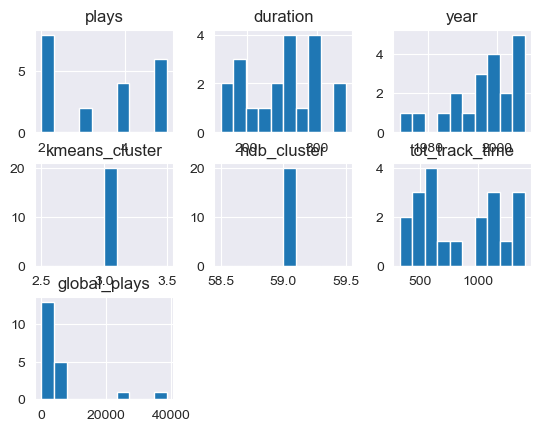

In [21]:
u_df.hist()

In [22]:
print(f"top 8 songs for  user {u_id}")
u_df[['title', 'release', 'artist_name', 'majority_genre', 'year', 'plays', 'global_plays']].head(8)

top 8 songs for  user 77448d704c1b9acc37037d400302ce7f8a9496c7


,title,release,artist_name,majority_genre,year,plays,global_plays
4386,Try Again,Keep An Eye On The Sky,Big Star,Rock,1972,5,113
4390,This Charming Man,The Sound Of The Smiths,The Smiths,Rock,1983,5,3847
4401,There Must Be A Better World Somewhere,Classics,B.B. King,Blues,1998,5,2911
4422,One Sweet Day,Greatest Hits,Mariah Carey feat. Boyz II Men,Pop,1995,5,2431
4428,Sayonara-Nostalgia,Yuugata Generation,Base Ball Bear,Rock,2005,5,26667
4467,Kyrie Eleison,Lo Mejor De Hevia,Hevia,World,2000,5,302
4389,Being Boring,Discography - Complete Singles Collection,Pet Shop Boys,Pop,1990,4,424
4412,Hacha Y Machete,A Man And His Music,Hector Lavoe,Latin,1976,4,368


In [23]:
print(f"top 8 songs for kmeans cluster {km_cid} to which user {u_id} belongs to")
km_df[['title', 'release', 'artist_name', 'majority_genre', 'year', 'plays', 'global_plays']].head(8)

top 8 songs for kmeans cluster 3 to which user 77448d704c1b9acc37037d400302ce7f8a9496c7 belongs to


,title,release,artist_name,majority_genre,year,plays,global_plays
60,Secrets,Waking Up,OneRepublic,Rock,2009,3902,106574
61,They Might Follow You,Tiny Vipers,Tiny Vipers,Pop,2007,3252,20440
62,You're The One,If There Was A Way,Dwight Yoakam,Country,1990,3004,199599
63,Revelry,Only By The Night,Kings Of Leon,Rock,2008,2949,144444
64,Use Somebody,Use Somebody,Kings Of Leon,Rock,2008,2933,55318
65,Undo,Vespertine Live,Björk,Rock,2001,2751,182600
66,Clocks,A Rush Of Blood To The Head,Coldplay,Rock,2002,2340,43238
67,Mia,First Love,Emmy The Great,Folk,2007,2283,13795


In [24]:
print(f"top 8 songs for hdb cluster {hdb_cid} to which user {u_id} belongs to")
hdb_df[['title', 'release', 'artist_name', 'majority_genre', 'year', 'plays', 'global_plays']].head(8)

top 8 songs for hdb cluster 59 to which user 77448d704c1b9acc37037d400302ce7f8a9496c7 belongs to


,title,release,artist_name,majority_genre,year,plays,global_plays
1200,You're The One,If There Was A Way,Dwight Yoakam,Country,1990,81513,199599
1201,Undo,Vespertine Live,Björk,Rock,2001,70171,182600
1202,Revelry,Only By The Night,Kings Of Leon,Rock,2008,54466,144444
1203,Secrets,Waking Up,OneRepublic,Rock,2009,35851,106574
1204,Tive Sim,Nova Bis-Cartola,Cartola,Latin,1974,27660,63869
1205,Invalid,Fermi Paradox,Tub Ring,Rock,2002,27497,71921
1206,Représente,Fat Come Back,Alliance Ethnik,Rap,1999,27073,70008
1207,Home,Up From Below,Edward Sharpe & The Magnetic Zeros,Rock,2009,22559,39672


In [25]:
total_songs_user = len(u_df)
total_artists_user = len(u_df['artist_name'])
total_genres_user = len(u_df['majority_genre'].dropna())
total_years_user = len(u_df['year'].dropna())

user_hdb_common_songs = set(u_df['song_id']).intersection(set(hdb_df['song_id']))
no_u_hdb_songs = len(user_hdb_common_songs)

user_kmeans_common_songs = set(u_df['song_id']).intersection(set(km_df['song_id']))
no_u_kmeans_songs = len(user_kmeans_common_songs)

kmeans_hdb_common_songs = set(km_df['song_id']).intersection(set(hdb_df['song_id']))
no_kmeans_hdb_songs = len(kmeans_hdb_common_songs)


def get_song_titles(song_ids_set, song_metadata_df):
    return song_metadata_df[song_metadata_df['song_id'].isin(song_ids_set)]['title'].tolist()


user_hdb_common_song_titles = get_song_titles(user_hdb_common_songs, song_meta)
user_kmeans_common_song_titles = get_song_titles(user_kmeans_common_songs, song_meta)
kmeans_hdb_common_song_titles = get_song_titles(kmeans_hdb_common_songs, song_meta)

print(
    f"Common song user-hdb: {user_hdb_common_song_titles} (Count: {no_u_hdb_songs}/{total_songs_user}, Ratio: {no_u_hdb_songs / total_songs_user:.2f})")
print(
    f"Common song user-kmeans: {user_kmeans_common_song_titles} (Count: {no_u_kmeans_songs}/{total_songs_user}, Ratio: {no_u_kmeans_songs / total_songs_user:.2f})")
print(
    f"Common song kmeans-hdb: {kmeans_hdb_common_song_titles} (Count: {no_kmeans_hdb_songs}, Ratio: {no_kmeans_hdb_songs / len(km_df):.2f})")

user_hdb_common_artists = set(u_df['artist_name']).intersection(set(hdb_df['artist_name']))
no_u_hdb_artists = len(user_hdb_common_artists)

user_kmeans_common_artists = set(u_df['artist_name']).intersection(set(km_df['artist_name']))
no_u_kmeans_artists = len(user_kmeans_common_artists)

kmeans_hdb_common_artists = set(km_df['artist_name']).intersection(set(hdb_df['artist_name']))
no_kmeans_hdb_artists = len(kmeans_hdb_common_artists)

print(
    f"\n\nCommon artist user-hdb: {user_hdb_common_artists} (Count: {no_u_hdb_artists}/{total_artists_user}, Ratio: {no_u_hdb_artists / total_artists_user:.2f})")
print(
    f"Common artist user-kmeans: {user_kmeans_common_artists} (Count: {no_u_kmeans_artists}/{total_artists_user}, Ratio: {no_u_kmeans_artists / total_artists_user:.2f})")
print(
    f"Common artist kmeans-hdb: {kmeans_hdb_common_artists} (Count: {no_kmeans_hdb_artists}, Ratio: {no_kmeans_hdb_artists / len(km_df['artist_name']):.2f})")

user_hdb_common_genres = set(u_df['majority_genre'].dropna()).intersection(set(hdb_df['majority_genre'].dropna()))
no_u_hdb_genres = len(user_hdb_common_genres)

user_kmeans_common_genres = set(u_df['majority_genre'].dropna()).intersection(set(km_df['majority_genre'].dropna()))
no_u_kmeans_genres = len(user_kmeans_common_genres)

kmeans_hdb_common_genres = set(km_df['majority_genre'].dropna()).intersection(set(hdb_df['majority_genre'].dropna()))
no_kmeans_hdb_genres = len(kmeans_hdb_common_genres)

print(
    f"\n\nCommon genre user-hdb: {user_hdb_common_genres} (Count: {no_u_hdb_genres}/{total_genres_user}, Ratio: {no_u_hdb_genres / total_genres_user:.2f})")
print(
    f"Common genre user-kmeans: {user_kmeans_common_genres} (Count: {no_u_kmeans_genres}/{total_genres_user}, Ratio: {no_u_kmeans_genres / total_genres_user:.2f})")
print(
    f"Common genre kmeans-hdb: {kmeans_hdb_common_genres} (Count: {no_kmeans_hdb_genres}, Ratio: {no_kmeans_hdb_genres / len(km_df['majority_genre'].dropna()):.2f})")

user_hdb_common_years = set(u_df['year'].dropna()).intersection(set(hdb_df['year'].dropna()))
no_u_hdb_years = len(user_hdb_common_years)

user_kmeans_common_years = set(u_df['year'].dropna()).intersection(set(km_df['year'].dropna()))
no_u_kmeans_years = len(user_kmeans_common_years)

kmeans_hdb_common_years = set(km_df['year'].dropna()).intersection(set(hdb_df['year'].dropna()))
no_kmeans_hdb_years = len(kmeans_hdb_common_years)

print(
    f"\n\nCommon year user-hdb: {user_hdb_common_years} (Count: {no_u_hdb_years}/{total_years_user}, Ratio: {no_u_hdb_years / total_years_user:.2f})")
print(
    f"Common year user-kmeans: {user_kmeans_common_years} (Count: {no_u_kmeans_years}/{total_years_user}, Ratio: {no_u_kmeans_years / total_years_user:.2f})")
print(
    f"Common year kmeans-hdb: {kmeans_hdb_common_years} (Count: {no_kmeans_hdb_years}, Ratio: {no_kmeans_hdb_years / len(km_df['year'].dropna()):.2f})")

Common song user-hdb: ['Yellow'] (Count: 1/20, Ratio: 0.05)
Common song user-kmeans: ['Yellow'] (Count: 1/20, Ratio: 0.05)
Common song kmeans-hdb: ['They Might Follow You', "You're The One", 'Secrets', 'Marry Me', 'Use Somebody', 'Clocks', 'Creep (Explicit)', 'Revelry', 'Home', 'Undo', 'Cosmic Love', 'Tive Sim', 'Yellow'] (Count: 13, Ratio: 0.65)


Common artist user-hdb: {'Coldplay'} (Count: 1/20, Ratio: 0.05)
Common artist user-kmeans: {'Coldplay'} (Count: 1/20, Ratio: 0.05)
Common artist kmeans-hdb: {'OneRepublic', 'Radiohead', 'Florence + The Machine', 'Tiny Vipers', 'Dwight Yoakam', 'Train', 'Edward Sharpe & The Magnetic Zeros', 'Björk', 'Cartola', 'Kings Of Leon', 'Coldplay'} (Count: 11, Ratio: 0.55)


Common genre user-hdb: {'Rock', 'Pop', 'Latin'} (Count: 3/20, Ratio: 0.15)
Common genre user-kmeans: {'Rock', 'Pop', 'Latin'} (Count: 3/20, Ratio: 0.15)
Common genre kmeans-hdb: {'Country', 'Rock', 'Pop', 'Latin'} (Count: 4, Ratio: 0.20)


Common year user-hdb: {1990, 1995, 1999, 2

In [26]:
# songs_df[songs_df['user_id'] == u_id]
# users_df[users_df['user_id'] == u_id]
# users_df['total_play_time'].hist()

In [27]:
songs_per_kmeans_cluster

,kmeans_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,0,SONYKOW12AB01849C9,4536,106574,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,1572.75111
1,0,SOBONKR12A58A7A7E0,4376,199599,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,6221.9898
2,0,SOFLJQZ12A6D4FADA6,3586,63869,Tive Sim,Nova Bis-Cartola,Cartola,ARRYVEO1187B98B5F5,127.242,1974,Latin,127.242
3,0,SOSXLTC12AF72A7F54,3301,144444,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
4,0,SOTWNDJ12A8C143984,2589,61642,Marry Me,Save Me_ San Francisco,Train,ARICCZI1187B9AEBB3,205.45261,2009,Pop,1643.62088
...,...,...,...,...,...,...,...,...,...,...,...,...
515,25,SOEPZQS12A8C1436C7,453,24551,Ghosts 'n' Stuff (Original Instrumental Mix),Ghosts 'n' Stuff,Deadmau5,ARJS9GN1187FB578C4,374.20363,2009,Electronic,374.20363
516,25,SOWCKVR12A8C142411,451,55318,Use Somebody,Use Somebody,Kings Of Leon,ARF2EHS1187B994F4E,231.81016,2008,Rock,695.43048
517,25,SOEGGET12AB017F441,450,3169,Wind Farm,Better Late Than Never,Lange,ARJGAUD1187FB505DA,463.62077,2007,Electronic,463.62077
518,25,SOTLASX12AB0183993,442,4036,Bust a Move,Legend Of The Black Shawarma,Infected Mushroom,ARY7DQ91187B98C85E,549.22404,2000,Rock,6041.46444


In [28]:
songs_per_hdb_cluster.head(20)

,hdb_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,-1,SOAUWYT12A81C206F1,15714,182600,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,8017.28273
1,-1,SOBONKR12A58A7A7E0,11902,199599,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,6221.9898
2,-1,SOSXLTC12AF72A7F54,9133,144444,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
3,-1,SOFLJQZ12A6D4FADA6,6033,63869,Tive Sim,Nova Bis-Cartola,Cartola,ARRYVEO1187B98B5F5,127.242,1974,Latin,127.242
4,-1,SONYKOW12AB01849C9,5986,106574,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,1572.75111
5,-1,SOOFYTN12A6D4F9B35,5134,70008,Représente,Fat Come Back,Alliance Ethnik,ARZO9UQ1187FB4D261,252.21179,1999,Rap,252.21179
6,-1,SOUFTBI12AB0183F65,5032,71921,Invalid,Fermi Paradox,Tub Ring,ARJFYA51187B9A9EDB,233.69098,2002,Rock,233.69098
7,-1,SOHFJAQ12AB017E4AF,4112,35282,West One (Shine On Me),The Crack/Grin And Bear It,The Ruts,ARHL1771187B99B168,338.96444,1980,Punk,338.96444
8,-1,SOCVTLJ12A6310F0FD,3858,43238,Clocks,A Rush Of Blood To The Head,Coldplay,ARJ7KF01187B98D717,307.51302,2002,Rock,615.02604
9,-1,SOWCKVR12A8C142411,3774,55318,Use Somebody,Use Somebody,Kings Of Leon,ARF2EHS1187B994F4E,231.81016,2008,Rock,695.43048


# Cluster Evaluation

In [29]:
cluster_totals = users_songs_clusters.groupby('kmeans_cluster').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

unique_users_per_cluster = users_songs_clusters.groupby('kmeans_cluster')['user_id'].nunique()
unique_users_per_cluster = users_songs_clusters.groupby('kmeans_cluster')['user_id'].nunique()

avg_plays_per_user = cluster_totals['total_plays'] / unique_users_per_cluster

avg_tot_track_time_per_user = cluster_totals['total_track_time'] / unique_users_per_cluster

k_cluster_summary_df = pd.DataFrame({
    'unique_users': unique_users_per_cluster,
    'total_plays': cluster_totals['total_plays'],
    'total_track_time': cluster_totals['total_track_time'],
    'avg_plays_per_user': avg_plays_per_user,
    'avg_total_track_time_per_user': avg_tot_track_time_per_user
})
display(k_cluster_summary_df)

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
kmeans_cluster,,,,,
0,15136,712545,169024958.85034,47.076176,11167.082376
1,19985,1345601,323459990.5613,67.330548,16185.138382
2,15859,2066311,501981487.78144,130.292641,31652.783138
3,10003,1459959,358687465.13617,145.952114,35857.989117
4,5980,640964,182198350.14184,107.184615,30467.951529
5,23195,969343,230725213.53273,41.791033,9947.1961
6,7329,1003472,244359925.09156,136.917997,33341.509768
7,11676,1380574,330853066.18107,118.240322,28336.165312
8,12603,1267905,312614265.68156,100.603428,24804.750114


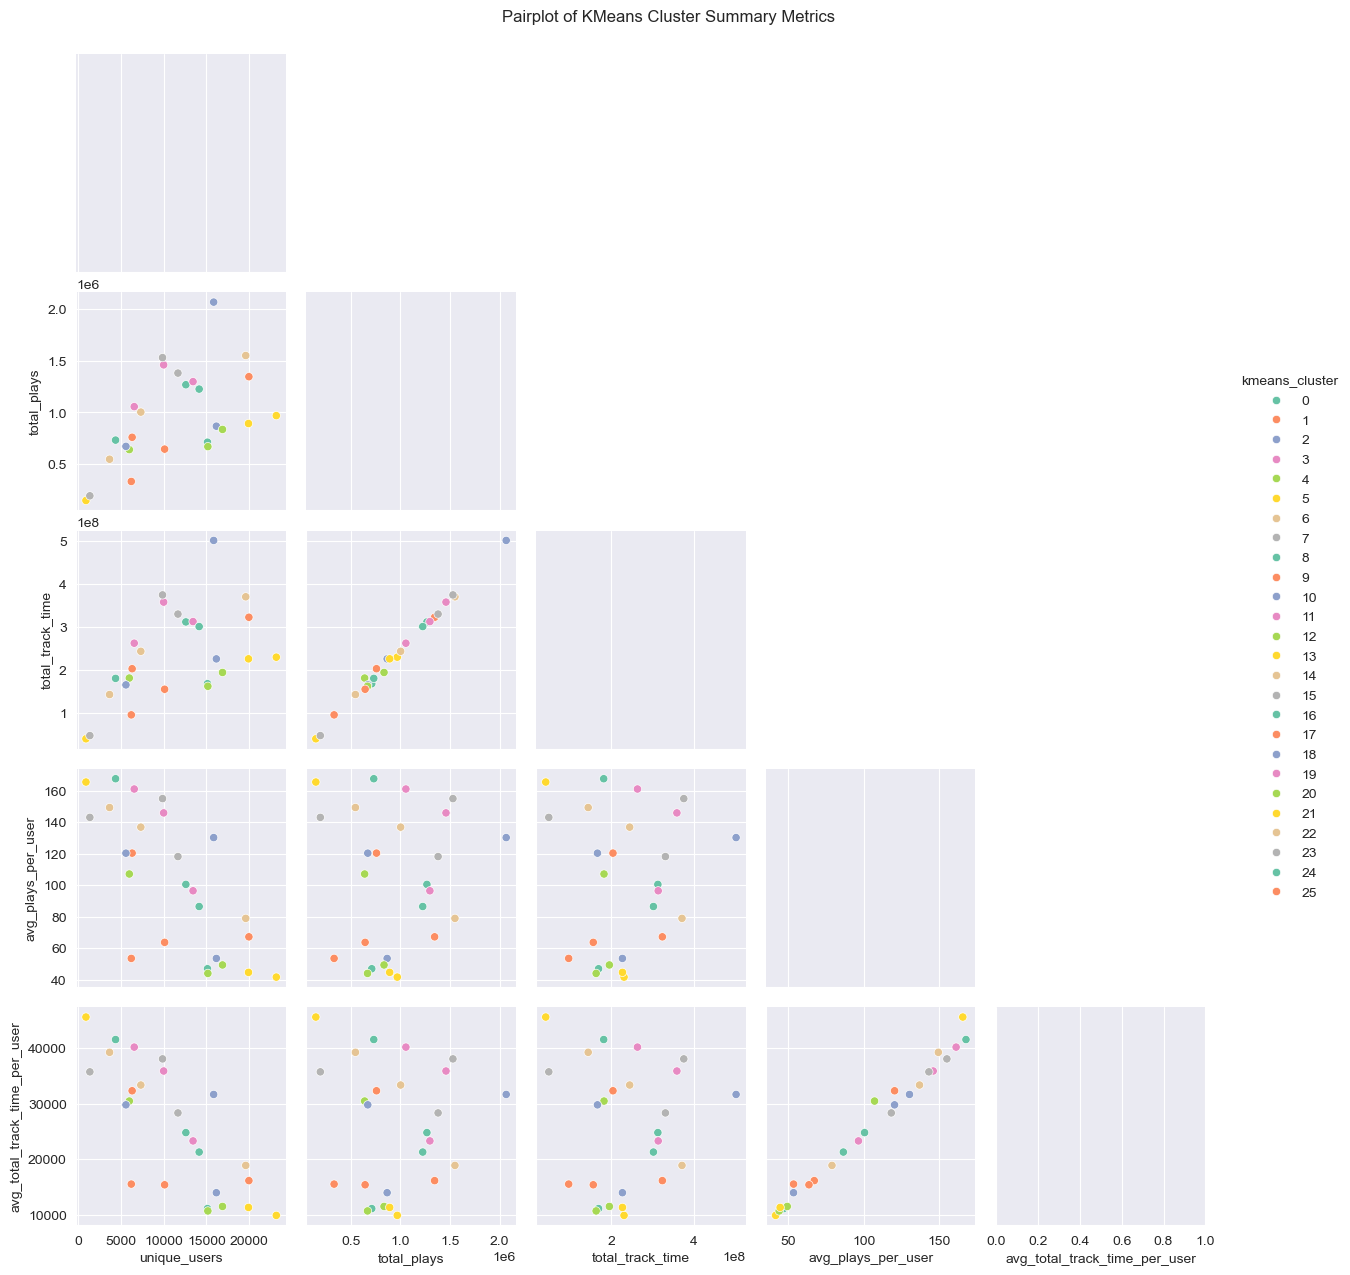

In [30]:
k_cluster_summary_df_plot = k_cluster_summary_df.reset_index()
sns.pairplot(k_cluster_summary_df_plot, hue='kmeans_cluster', palette='Set2', corner=True, diag_kind='kde')
plt.suptitle('Pairplot of KMeans Cluster Summary Metrics', y=1.02)
plt.show()

In [31]:
cluster_totals = users_songs_clusters.groupby('hdb_cluster').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

unique_users_per_cluster = users_songs_clusters.groupby('hdb_cluster')['user_id'].nunique()
unique_users_per_cluster = users_songs_clusters.groupby('hdb_cluster')['user_id'].nunique()

avg_plays_per_user = cluster_totals['total_plays'] / unique_users_per_cluster

avg_tot_track_time_per_user = cluster_totals['total_track_time'] / unique_users_per_cluster

cluster_summary_df = pd.DataFrame({
    'unique_users': unique_users_per_cluster,
    'total_plays': cluster_totals['total_plays'],
    'total_track_time': cluster_totals['total_track_time'],
    'avg_plays_per_user': avg_plays_per_user,
    'avg_total_track_time_per_user': avg_tot_track_time_per_user
})
display(cluster_summary_df)

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
hdb_cluster,,,,,
-1,28929,2549503,647133401.06197,88.129662,22369.71209
0,3779,295431,67780575.70395,78.177031,17936.114238
1,2033,150852,36072863.53451,74.201672,17743.661355
2,330,23457,5486660.16825,71.081818,16626.242934
3,4288,311168,74523580.88918,72.567164,17379.566439
...,...,...,...,...,...
56,594,35598,10561636.73242,59.929293,17780.53322
57,1332,89308,22033305.63321,67.048048,16541.520746
58,33829,2693833,670804091.94945,79.630879,19829.261638


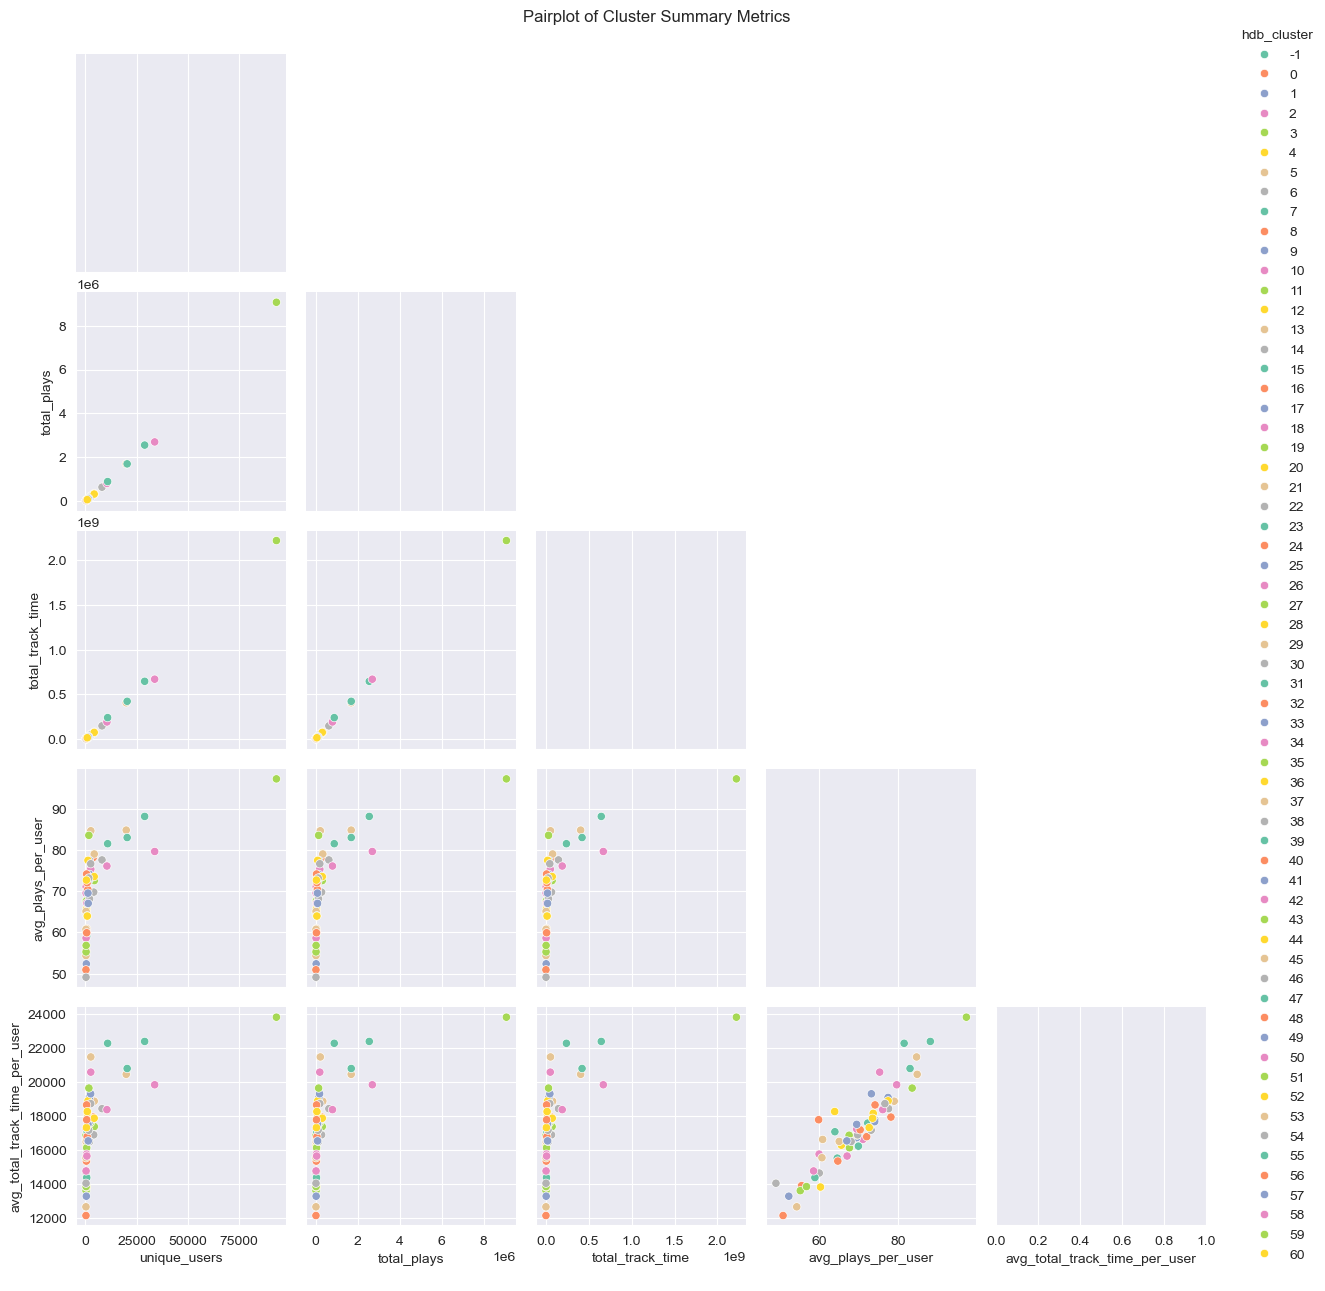

In [32]:
cluster_summary_df_plot = cluster_summary_df.reset_index()
sns.pairplot(cluster_summary_df_plot, hue='hdb_cluster', palette='Set2', corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Cluster Summary Metrics', y=1.02)
plt.show()